In [29]:
import numpy as np
from matplotlib import pyplot as plt

In [163]:
def generator_regression(features, labels, batch_size, epoch_size, rebalance=False, rebalanced_thr=0): 
    
    """
    
    Given the "features" array, this function  returns "batch_size" epochs of size "epoch_size" balanced or unbalanced.
    Batches can be equally sampled by two distributions defined by "rebalanced_thr" if "rebalance" is True. 
    In the rebalance=True case returned batches are shuffled. Corresponding "labels" are returned in the same manner.
    
    params: 
    features (np array) : data array in shape (time, num_channels), 
    labels (np array) : in shape (time),
    batch_size (int) : number of samples per epoch, equivallent to keras model.fit batch_size, 
    epoch_size (int) : time dimension of data vector defined as one training sample
                       dependent on the sampling frequency!,
    rebalance (boolean) : if True data is sampled evenly from the greater and smaller rebalanced_thr distributions, 
    rebalanced_thr (float) : defines rebalancing thresholds for two distributions 
    
    returns:
    batch_features (np array) : batch array in shape (batch_size, 1, num_channels, epoch_size), 
    batch_labels (np array) : label array of size batch_size
    
    The batch_features shape is necessary for tensorflow train
    """
    chans = features.shape[1]
    batch_features = np.zeros([batch_size, 1, chans, epoch_size])  # definition of returned arrays
    batch_labels = np.zeros([batch_size]) 
    
    # the True statement is neccessary due to the "endless" model.fit iterations
    # it is hence terminated by the number of epoch being specified 
    
    while True:
        for idx_label in np.arange(epoch_size, features.shape[0]-batch_size, batch_size): 
            for i in range(batch_size):

                for ch in range(chans):
                    batch_features[i,0,ch,:] = features[(idx_label+i-epoch_size):i+idx_label,ch]
                batch_labels[i] = labels[idx_label+i]
                
            if rebalance == True:    
                
                # resample balancing: 
                # the indices of respective above and below threshold values are concatenated "num_pos" times
                # respectively the distribution with less samples is repeated 
                # thus random sampling is avoided, but data samples are only concatenated 
                
                dat_ = (batch_features, batch_labels)
                ind_below = np.where(batch_labels<=rebalanced_thr)[0]
                ind_above = np.where(batch_labels>rebalanced_thr)[0]
                
                # unformly sample from both distributions
                ind_sample_below = np.random.randint(0, ind_below.shape[0], size=int(batch_size/2))
                ind_sample_above = np.random.randint(0, ind_above.shape[0], size=int(batch_size/2))                
                
                batch_features_ = np.concatenate((batch_features[ind_below[ind_sample_below],:,:,:], \
                                batch_features[ind_above[ind_sample_above],:,:,:]), axis=0)
                batch_labels_ = np.concatenate((batch_labels[ind_below[ind_sample_below]], \
                                batch_labels[ind_above[ind_sample_above]]), axis=0)
                yield batch_features_, batch_labels_, [None]
            else:
                yield batch_features, batch_labels, [None]
                

In [168]:
epoch_size = 128 # dependent on fs, here fs=1kHz: epoch_size = 128 ms 
batch_size = 200 # return data of size epoch_size * batch_size 

# outer loop: run through features with steps: batch_size
# inner loop: run through the batch_size segment 

In [169]:
features = np.random.random([5000,6])
labels = np.abs(np.random.laplace(size=5000))

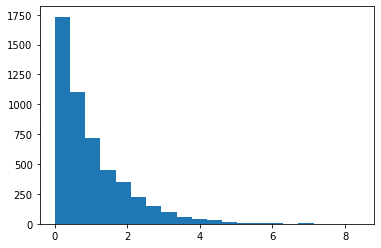

In [170]:
# THOSE ARE the laplacian generated labels
plt.hist(labels, bins=20)
plt.show()

In [182]:
# defing a generator will now give us labels with two distributions of equal sizes
# Above and below the treshold 

In [171]:
gen = generator_regression(features, labels, batch_size, epoch_size, rebalance=True, rebalanced_thr=4)

In [172]:
batch_feature, batch_label, _ = next(gen)

In [181]:
batch_feature.shape

(200, 1, 6, 128)

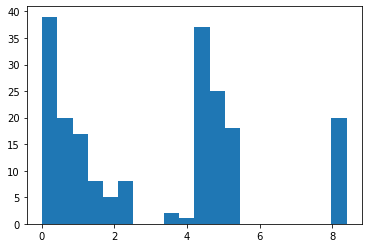

In [177]:
plt.hist(batch_label, bins=20)
plt.show()

In [ ]:
# adding now a threshold at 0.5 will yield different sampled labels

In [178]:
gen = generator_regression(features, labels, batch_size, epoch_size, rebalance=True, rebalanced_thr=0.5)

In [179]:
batch_feature, batch_label, _ = next(gen)

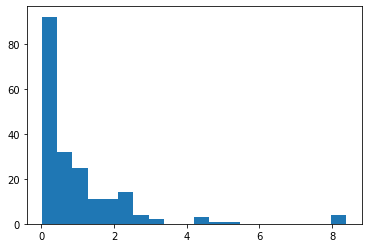

In [180]:
plt.hist(batch_label, bins=20)
plt.show()

In [ ]:
# now don't resample, this will yield the origininal distribution

In [183]:
gen = generator_regression(features, labels, batch_size, epoch_size, rebalance=False)

In [184]:
batch_feature, batch_label, _ = next(gen)

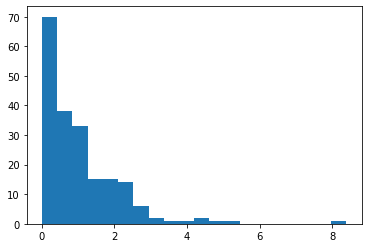

In [185]:
plt.hist(batch_label, bins=20)
plt.show()